In [137]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1 import AxesGrid
import mpl_toolkits as mpl
from scipy.stats import chi2, norm
#import warnings
#warnings.filterwarnings("ignore")

plt.rcParams["mpl_toolkits.legacy_colorbar"] = False

s=2
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#plt stuff
plt.rcParams["figure.figsize"] = (20,10)

# Model

In [138]:
#set up the network
def NN(num_classes=10):
    
    features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Flatten(),
        torch.nn.Linear(4 * 4 * 32, num_classes)
    )
    return(features)

mnist_model = NN()
loss_function = torch.nn.CrossEntropyLoss()
mnist_train_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3, weight_decay=5e-4)

MNIST_PATH = "../trained_weights/MNIST/MNIST_weights_seed={}.pth".format(s)

In [139]:
mnist_model.load_state_dict(torch.load(MNIST_PATH), strict=False)
mnist_model.eval()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=512, out_features=10, bias=True)
)

In [140]:
for param in mnist_model.parameters():
    print(param.size())

torch.Size([32, 1, 5, 5])
torch.Size([32])
torch.Size([32, 32, 5, 5])
torch.Size([32])
torch.Size([10, 512])
torch.Size([10])


# Laplace Approximation of the Weights with DiagHessian()

In [141]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = torch.nn.CrossEntropyLoss()

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    
    return(Cov_diag)

In [142]:
MNIST_NN_Std_prec_1 = torch.load('Hessians/MNIST/Hessian_prec1_seed{}.pth'.format(s))
MNIST_NN_Std_prec_01 = torch.load('Hessians/MNIST/Hessian_prec01_seed{}.pth'.format(s))
MNIST_NN_Std_prec_001 = torch.load('Hessians/MNIST/Hessian_prec001_seed{}.pth'.format(s))
MNIST_NN_Std_prec_0001 = torch.load('Hessians/MNIST/Hessian_prec0001_seed{}.pth'.format(s))
MNIST_NN_Std_prec_00001 = torch.load('Hessians/MNIST/Hessian_prec00001_seed{}.pth'.format(s))
MNIST_NN_Std_prec_000001 = torch.load('Hessians/MNIST/Hessian_prec000001_seed{}.pth'.format(s))

# Analyzing the First Conv-Layer
* visualization of the uncertainty in the 32 kernels
* visualization of the weights in the 32 kerlens
* histogram of the uncertainty to see the distribution
* correlation of the uncertainty and the weights

### Uncertainties

/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The set_cmap function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_cmap instead.
  del sys.path[0]
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  del sys.path[0]
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Use the colorbar set_ticks() method instead.
  from ipykernel import kernelapp as app


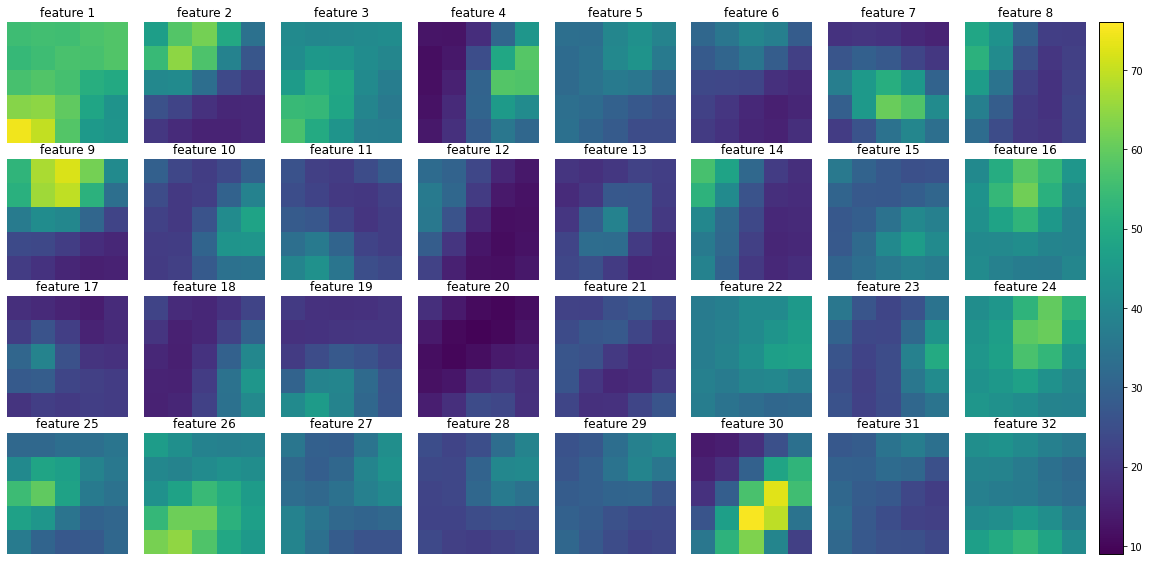

In [143]:
fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)
min_val = np.floor(min(list(torch.flatten(MNIST_NN_Std_prec_00001[0]))))
max_val = np.ceil(max(list(torch.flatten(MNIST_NN_Std_prec_00001[0]))))
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(MNIST_NN_Std_prec_00001[0][i][0], vmin=min_val, vmax=max_val)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 10))
plt.show()

### Weights

/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The set_cmap function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_cmap instead.
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Use the colorbar set_ticks() method instead.


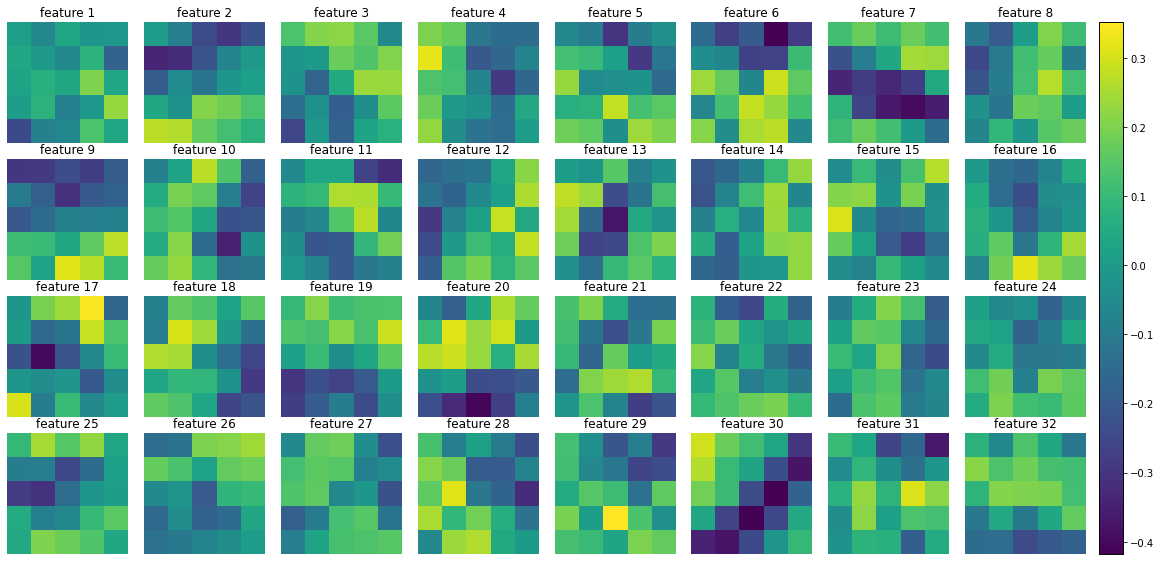

In [144]:
for name, parameters in mnist_model.named_parameters():
    if name == '0.weight':
        first_conv_weights = parameters

params_arr = first_conv_weights.detach().numpy()
fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)
min_val = min(list(torch.flatten(first_conv_weights).detach().numpy()))
max_val = max(list(torch.flatten(first_conv_weights).detach().numpy()))
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(params_arr[i][0], vmin=min_val, vmax=max_val)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 0.1))
plt.show()

## Distribution of the Uncertainty and Weights

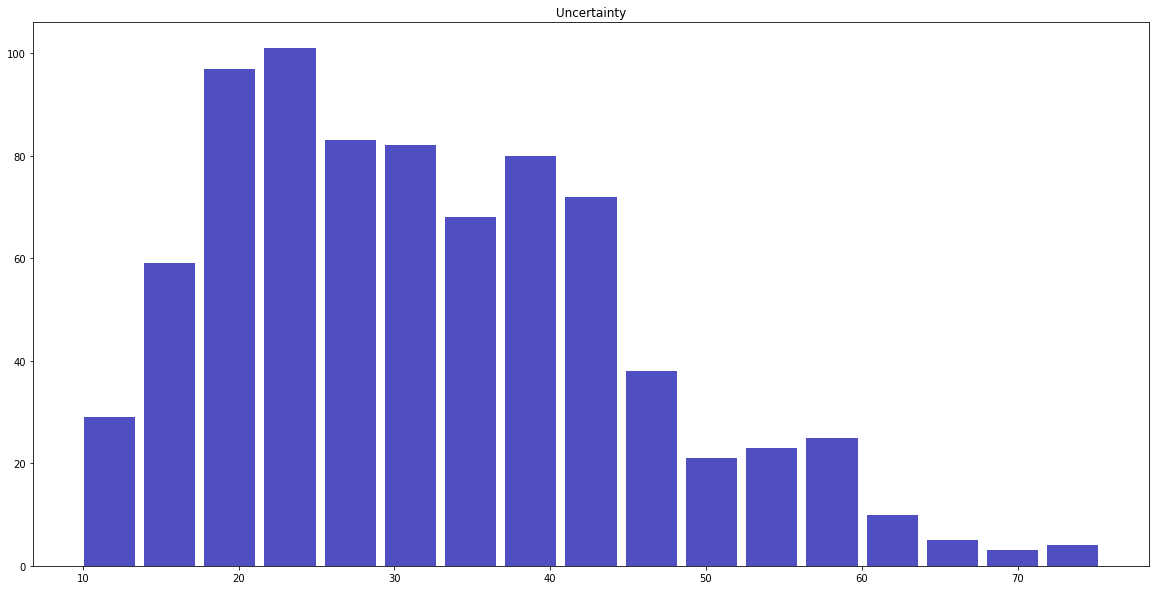

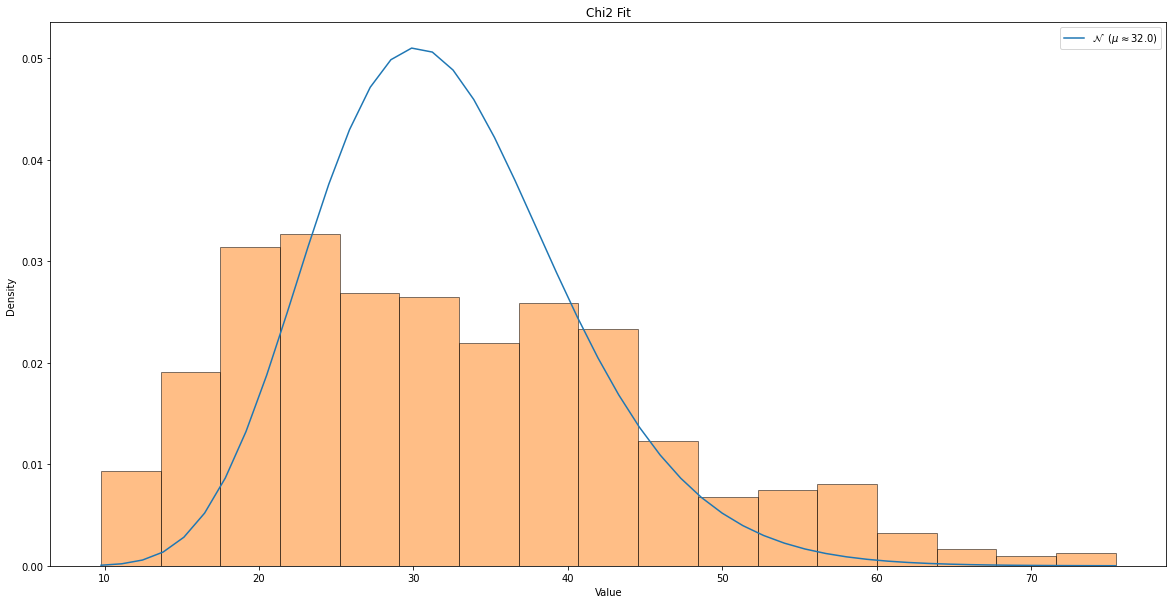

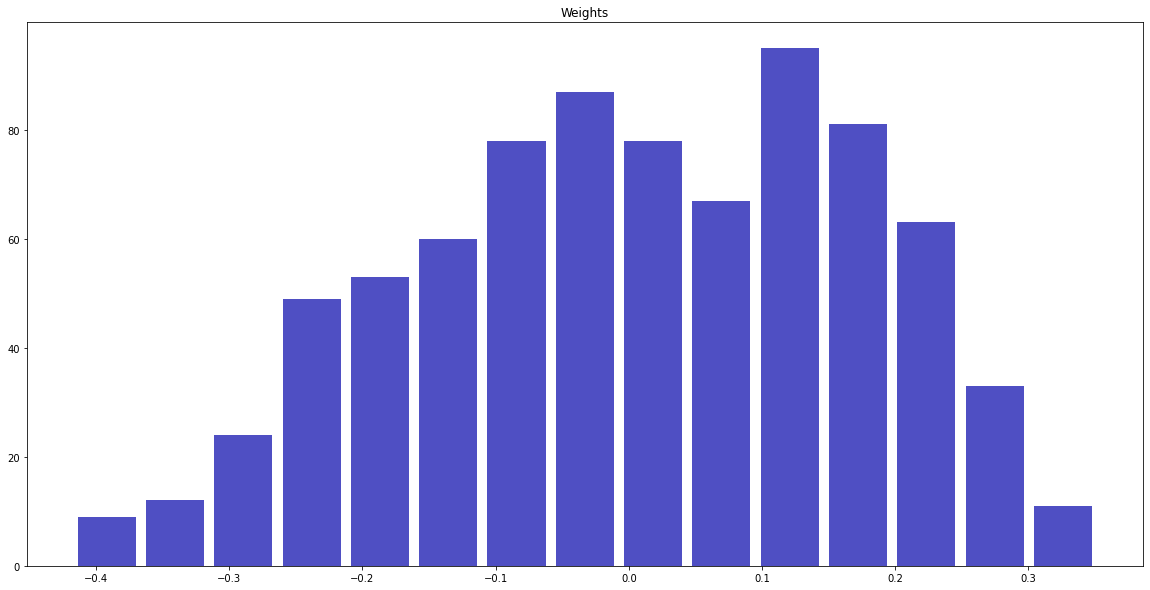

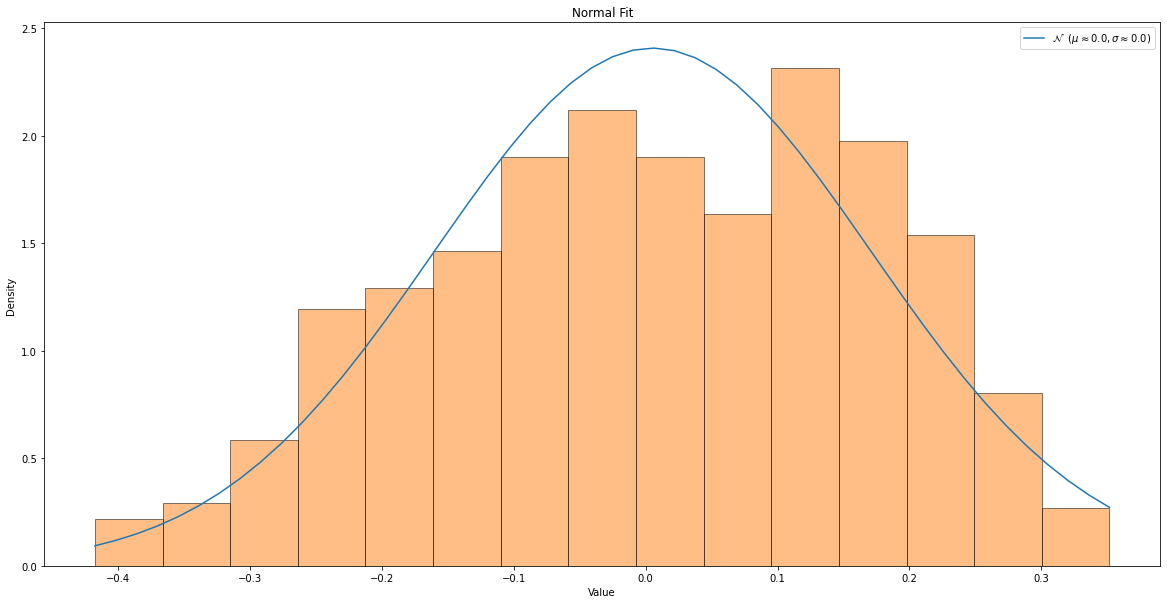

In [145]:
plt.hist(torch.flatten(MNIST_NN_Std_prec_00001[0]), bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Uncertainty')
plt.show()
#chi2
std = np.std(MNIST_NN_Std_prec_00001[0].detach().numpy(), ddof=1)
mean = np.mean(MNIST_NN_Std_prec_00001[0].detach().numpy())
domain = np.linspace(np.min(MNIST_NN_Std_prec_00001[0].detach().numpy()), np.max(MNIST_NN_Std_prec_00001[0].detach().numpy()))
plt.plot(domain, chi2.pdf(domain, mean), 
        label='$\mathcal{N}$  ' + f'$( \mu \\approx {round(mean)})$')
plt.hist(torch.flatten(MNIST_NN_Std_prec_00001[0]).detach().numpy(), bins='auto', edgecolor='black', alpha=.5, density=True)
plt.title("Chi2 Fit")
plt.xlabel("Value")
plt.ylabel("Density ")
plt.legend()
plt.show()

#__________
plt.hist(torch.flatten(first_conv_weights).detach().numpy(), bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Weights')
plt.show()
#norm 
std = np.std(first_conv_weights.detach().numpy(), ddof=1)
mean = np.mean(first_conv_weights.detach().numpy())
domain = np.linspace(np.min(first_conv_weights.detach().numpy()), np.max(first_conv_weights.detach().numpy()))
plt.plot(domain, norm.pdf(domain, mean, std), 
        label='$\mathcal{N}$  ' + f'$( \mu \\approx {round(mean)}, \sigma \\approx {round(std)})$')
plt.hist(torch.flatten(first_conv_weights).detach().numpy(), bins='auto', edgecolor='black', alpha=.5, density=True)
plt.title("Normal Fit")
plt.xlabel("Value")
plt.ylabel("Density ")
plt.legend()
plt.show()

#__________

## Correlation between Uncertainty and Size of Weights


Pearsons correlation: -0.515


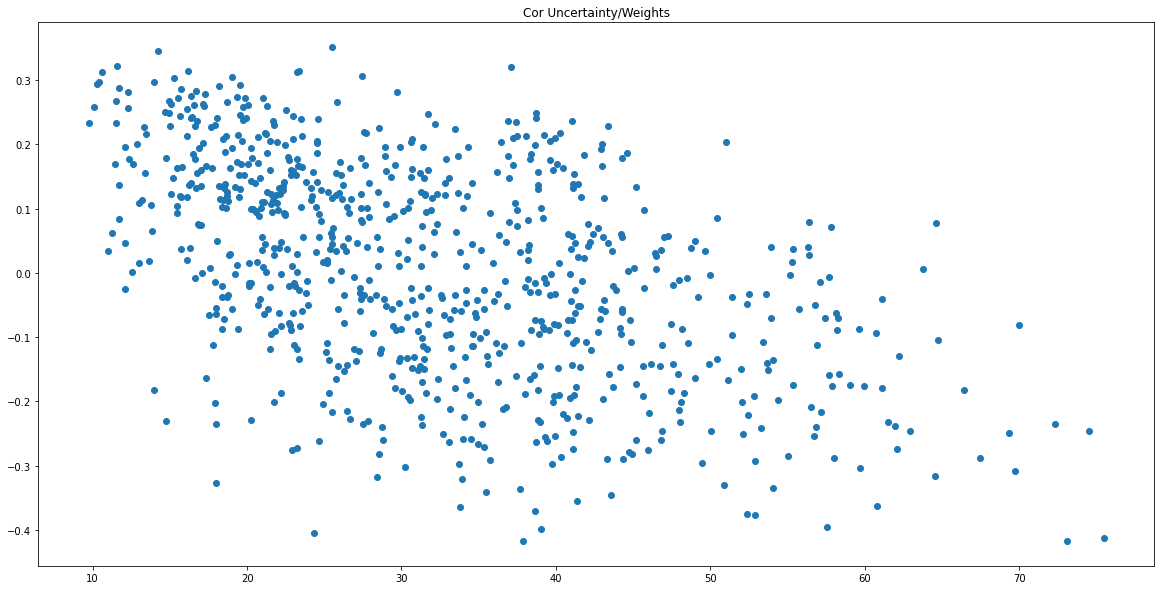

In [146]:
conv2_weights_flattened = torch.flatten(first_conv_weights)
conv2_uncertainties_flattened = torch.flatten(MNIST_NN_Std_prec_00001[0])
plt.scatter(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
plt.title('Cor Uncertainty/Weights')
#print(np.cov(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy()))
corr, _ = pearsonr(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
print()
print('Pearsons correlation: %.3f' % corr)

# Analyzing the Second Conv-Layer

## Uncertainties

/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The set_cmap function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_cmap instead.
  
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Use the colorbar set_ticks() method instead.
  app.launch_new_instance()


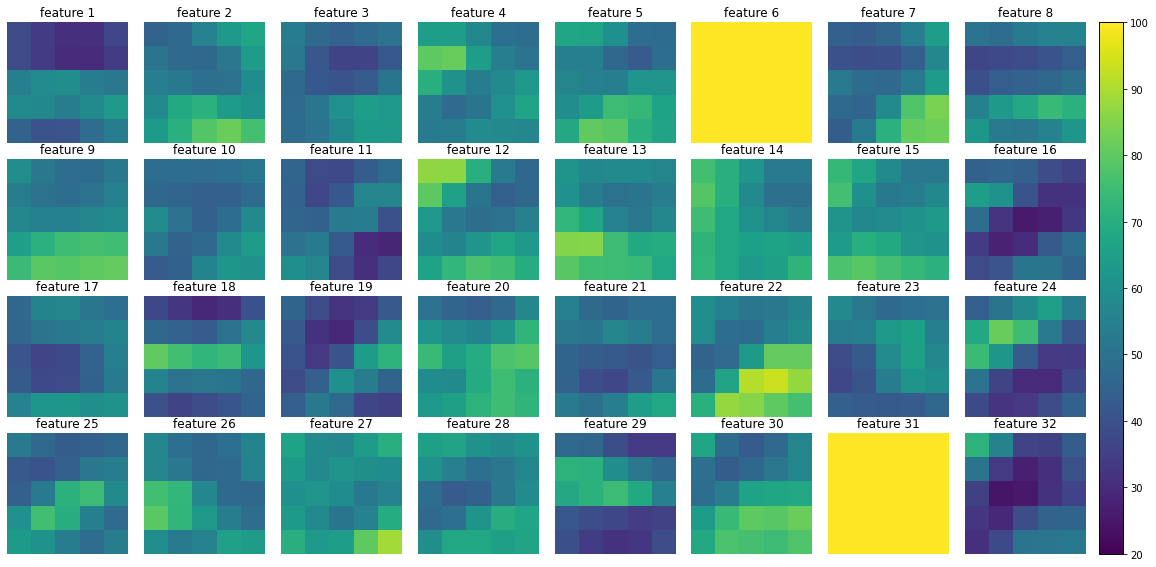

In [147]:
j = 5

fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)

for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(MNIST_NN_Std_prec_00001[2][i][j], vmin=20, vmax=100)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(20, 100, 10))
plt.show()

## Weights

/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The set_cmap function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_cmap instead.
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Use the colorbar set_ticks() method instead.


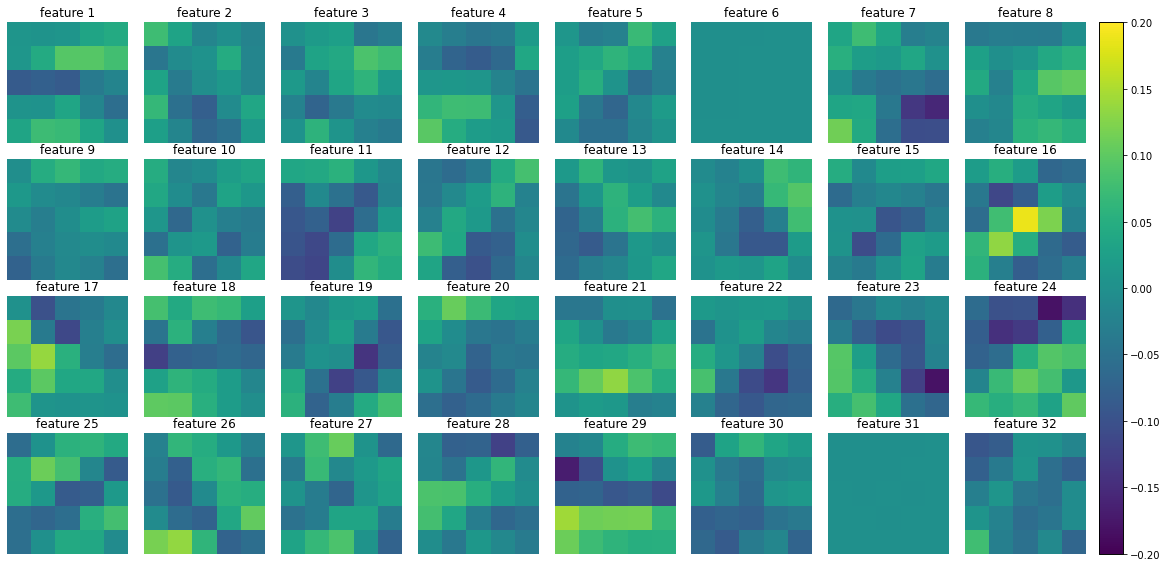

In [148]:
#j = 5
#mpl.legacy_colorbar.rcParams["mpl_toolkits.legacy_colorbar"] = False

for name, parameters in mnist_model.named_parameters():
    if name == '3.weight':
        second_conv_weights = parameters

params_arr = second_conv_weights.detach().numpy()
fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)
min_val = np.round(min(list(torch.flatten(second_conv_weights[j]).detach().numpy())), 1)
max_val = np.round(max(list(torch.flatten(second_conv_weights[j]).detach().numpy())), 1)

for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(params_arr[i][j], vmin=-0.2, vmax=0.2)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 0.1))
plt.show()

In [149]:
print(torch.flatten(MNIST_NN_Std_prec_00001[2]))
print(torch.flatten(second_conv_weights).detach())

tensor([77.8476, 77.3193, 77.5412,  ..., 32.2943, 36.5772, 44.8202])
tensor([-0.0168,  0.0102, -0.0060,  ...,  0.0261, -0.0226,  0.0112])


## Distribution of the Uncertainty and Weights

In [164]:
def clean():
    weights_flat = torch.flatten(second_conv_weights)
    uncerts_flat = torch.flatten(MNIST_NN_Std_prec_00001[2])
    print(len(weights_flat), weights_flat.size(), len(uncerts_flat))
    for i, elem in enumerate(uncerts_flat):
        if elem > 99.0:
            uncerts_flat = torch.cat([uncerts_flat[0:i], uncerts_flat[i+1:]])
            weights_flat = torch.cat([weights_flat[0:i], weights_flat[i+1:]])

    print(len(weights_flat), len(uncerts_flat))
    return weights_flat, uncerts_flat

#clean()

In [222]:
uncerts = MNIST_NN_Std_prec_00001[2]
cut = torch.cat([uncerts[0:5], uncerts[6:]])
cut2 = torch.cat([cut[0:29], cut[30:]])

wghts = second_conv_weights
cutt = torch.cat([wghts[0:5], wghts[6:]])
cutt2 = torch.cat([cutt[0:29], cutt[30:]])

tensor([1.])


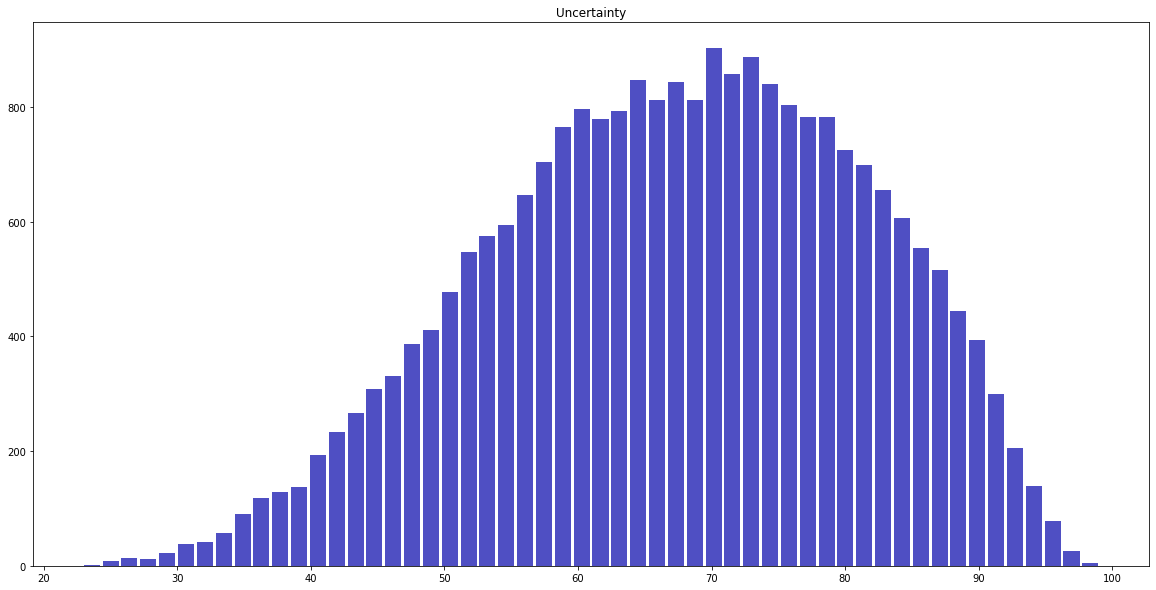

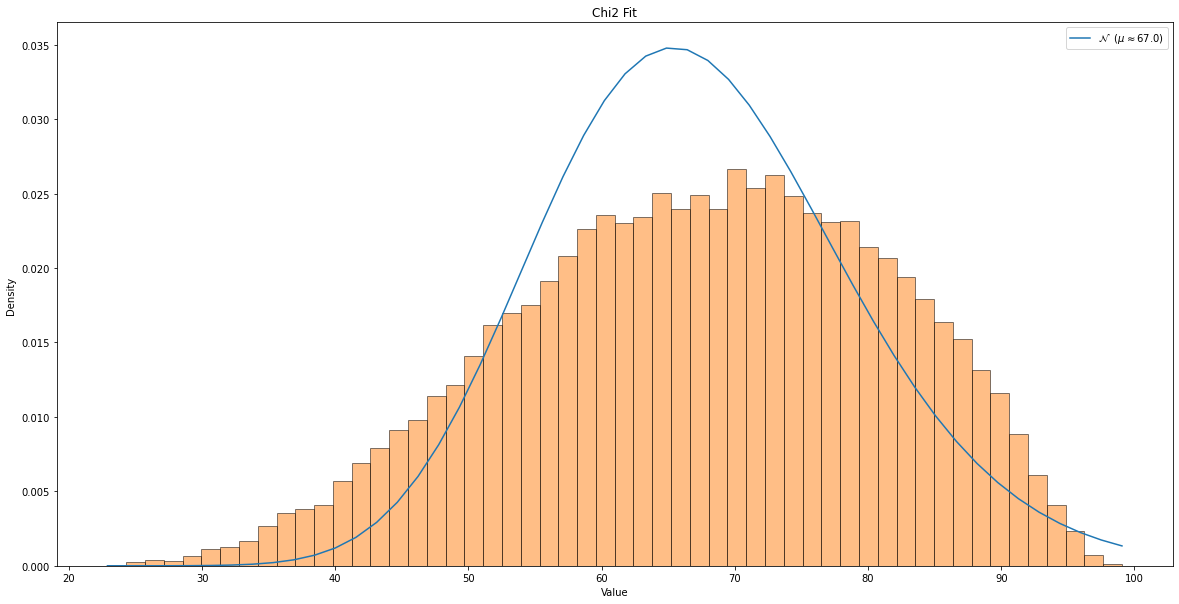

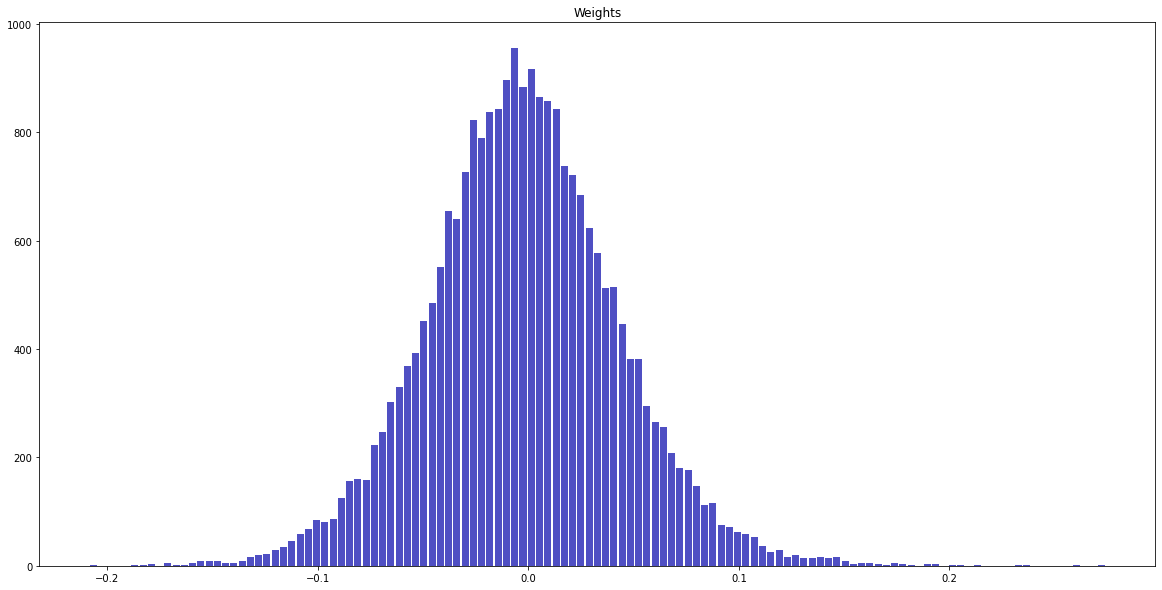

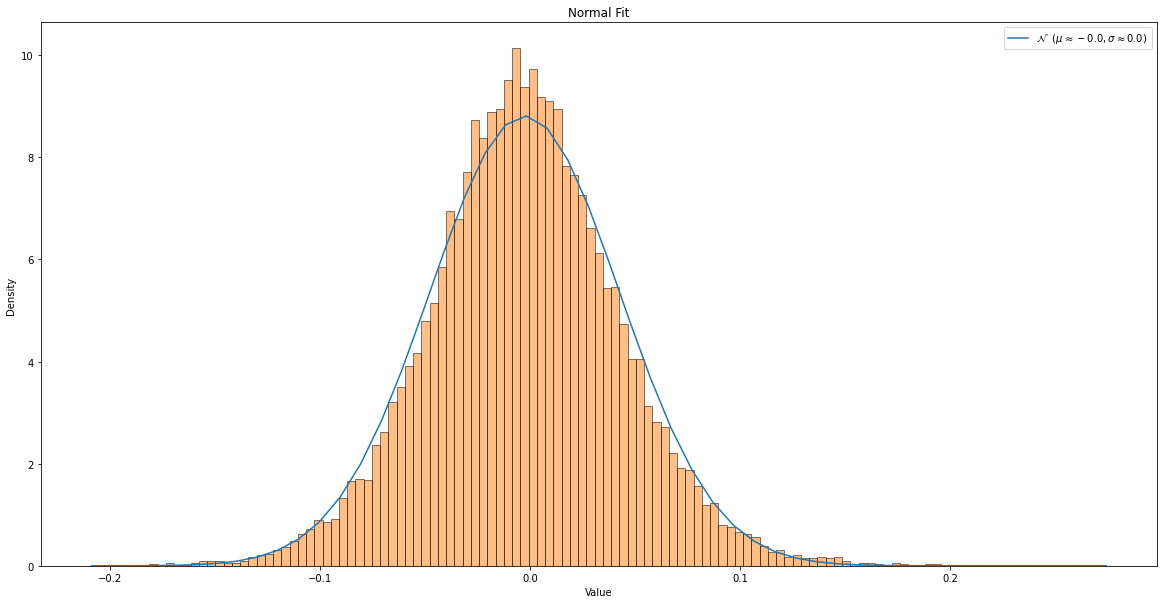

In [223]:
#plt.hist(torch.flatten(MNIST_NN_Std_prec_00001[2]).detach().numpy(), bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.hist(torch.flatten(cut2), bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Uncertainty')
plt.show()
#chi2
std = np.std(cut2.detach().numpy(), ddof=1)
mean = np.mean(cut2.detach().numpy())
domain = np.linspace(np.min(cut2.detach().numpy()), np.max(cut2.detach().numpy()))
plt.plot(domain, chi2.pdf(domain, mean), 
        label='$\mathcal{N}$  ' + f'$( \mu \\approx {round(mean)})$')
plt.hist(torch.flatten(cut2).detach().numpy(), bins='auto', edgecolor='black', alpha=.5, density=True)
plt.title("Chi2 Fit")
plt.xlabel("Value")
plt.ylabel("Density ")
plt.legend()
plt.show()

#__________
plt.hist(torch.flatten(cutt2).detach().numpy(), bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Weights')
plt.show()
#norm 
std = np.std(cutt2.detach().numpy(), ddof=1)
mean = np.mean(cutt2.detach().numpy())
domain = np.linspace(np.min(cutt2.detach().numpy()), np.max(cutt2.detach().numpy()))
plt.plot(domain, norm.pdf(domain, mean, std), 
        label='$\mathcal{N}$  ' + f'$( \mu \\approx {round(mean)}, \sigma \\approx {round(std)})$')
plt.hist(torch.flatten(cutt2).detach().numpy(), bins='auto', edgecolor='black', alpha=.5, density=True)
plt.title("Normal Fit")
plt.xlabel("Value")
plt.ylabel("Density ")
plt.legend()
plt.show()

#__________

## Correlation between Uncertainty and Size of Weights

Pearsons correlation: -0.286


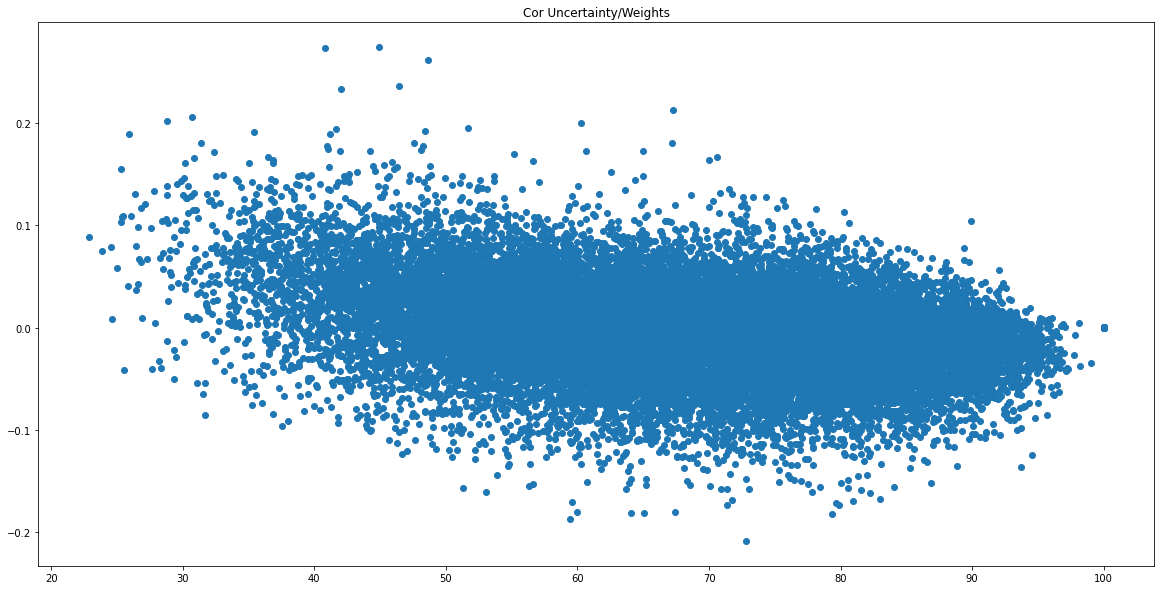

In [153]:
conv2_weights_flattened = torch.flatten(second_conv_weights)
conv2_uncertainties_flattened = torch.flatten(MNIST_NN_Std_prec_00001[2])

plt.scatter(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
plt.title('Cor Uncertainty/Weights')
#print(np.cov(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy()))
corr, _ = pearsonr(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
print('Pearsons correlation: %.3f' % corr)

# Analyzing the Linear Layer (last layer)

## Uncertainty

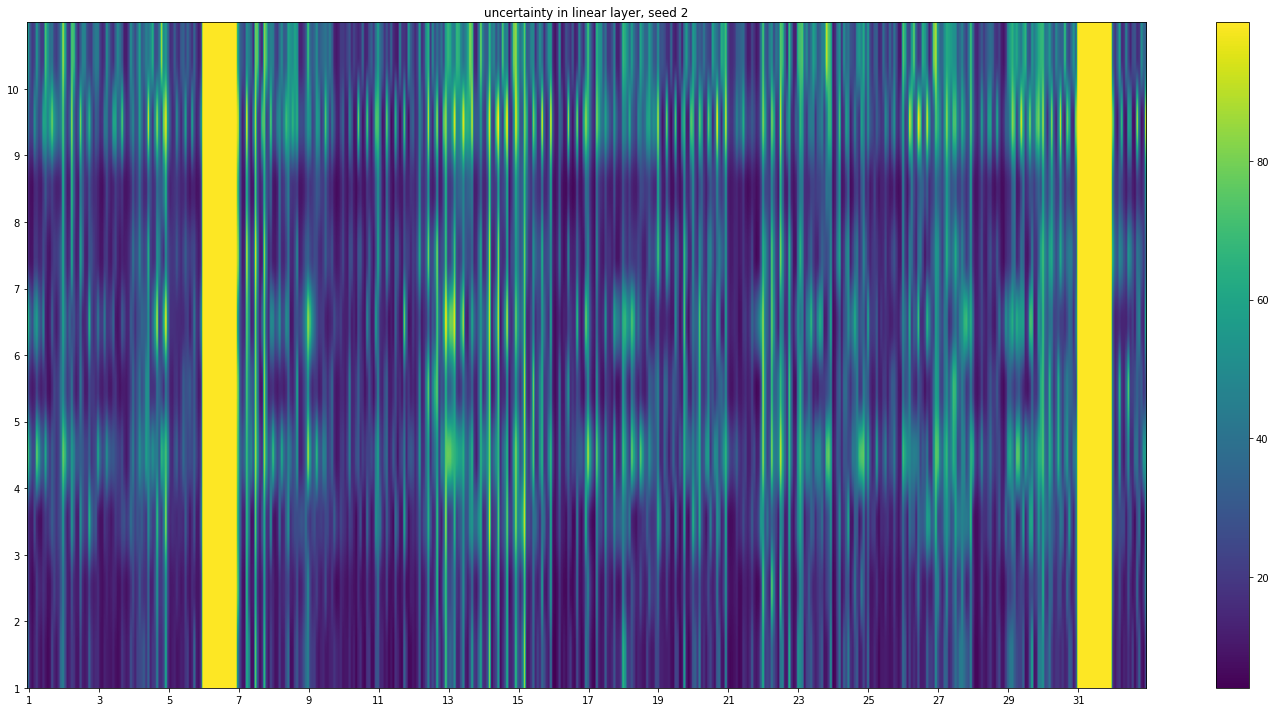

In [154]:
plt.imshow(MNIST_NN_Std_prec_00001[4], extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_yticks(np.arange(0, 1, 0.1));
ax.set_yticklabels(np.arange(1,11,1));
ax.set_title('uncertainty in linear layer, seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
plt.show()

## Weights

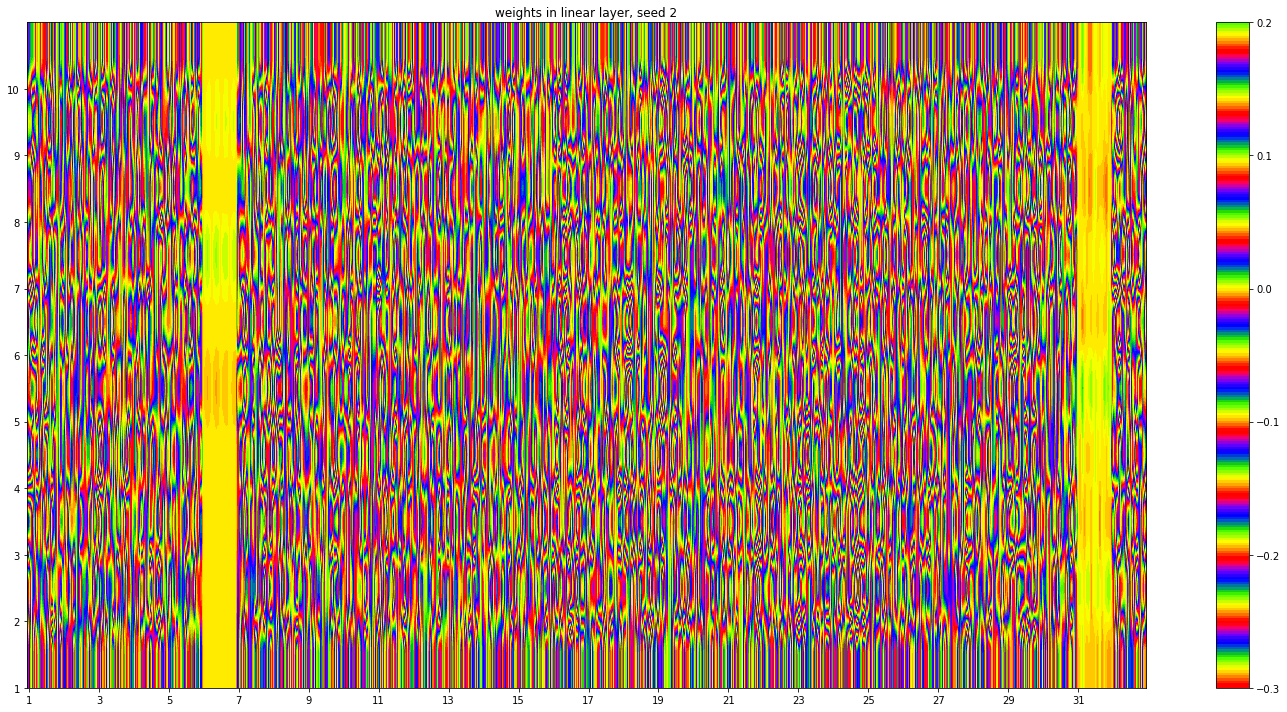

In [155]:
for name, parameters in mnist_model.named_parameters():
    if name == '7.weight':
        linear_weights = parameters

params_arr = linear_weights.detach().numpy()
min_val = np.round(min(list(torch.flatten(linear_weights).detach().numpy())), 1)
max_val = np.round(max(list(torch.flatten(linear_weights).detach().numpy())), 1)

plt.imshow(params_arr, cmap='prism', extent=[0,512,0,1],  aspect='auto', vmin=min_val, vmax=max_val)
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_yticks(np.arange(0, 1, 0.1));
ax.set_yticklabels(np.arange(1,11,1));
ax.set_title('weights in linear layer, seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
im = plt.show()

## Distribution of Uncertainty and Weights

In [238]:
npuncert = MNIST_NN_Std_prec_00001[4].detach().numpy()

    
npuncert1 = npuncert[npuncert < 99.99]

npweight = linear_weights.detach().numpy()

npweight1 = npweight[(npweight > 0.0001) & (npweight < -0.0001)]

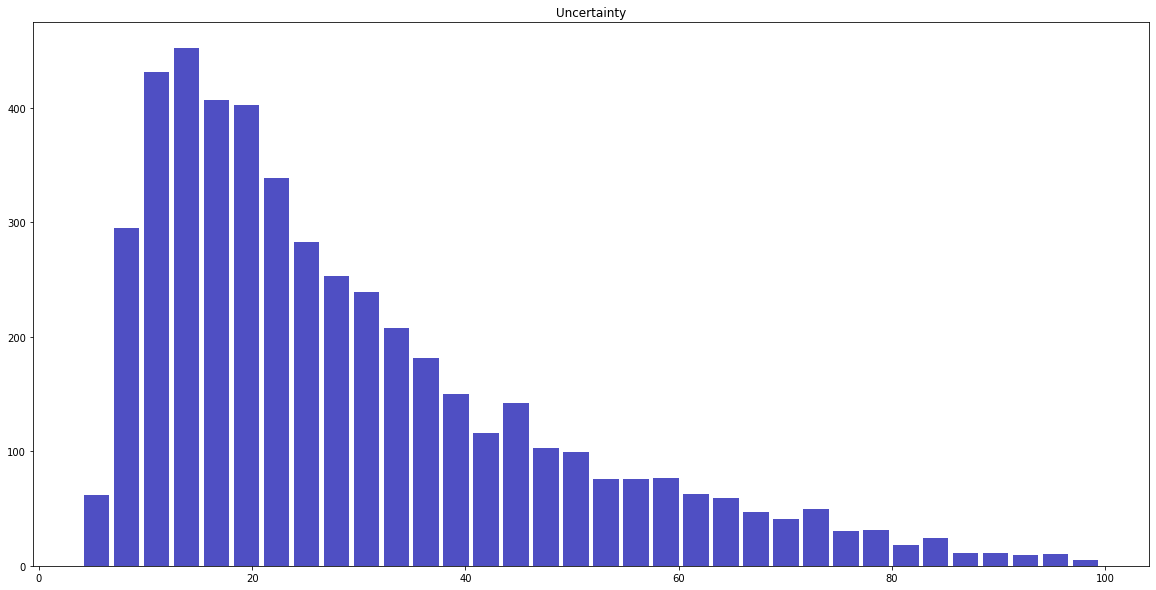

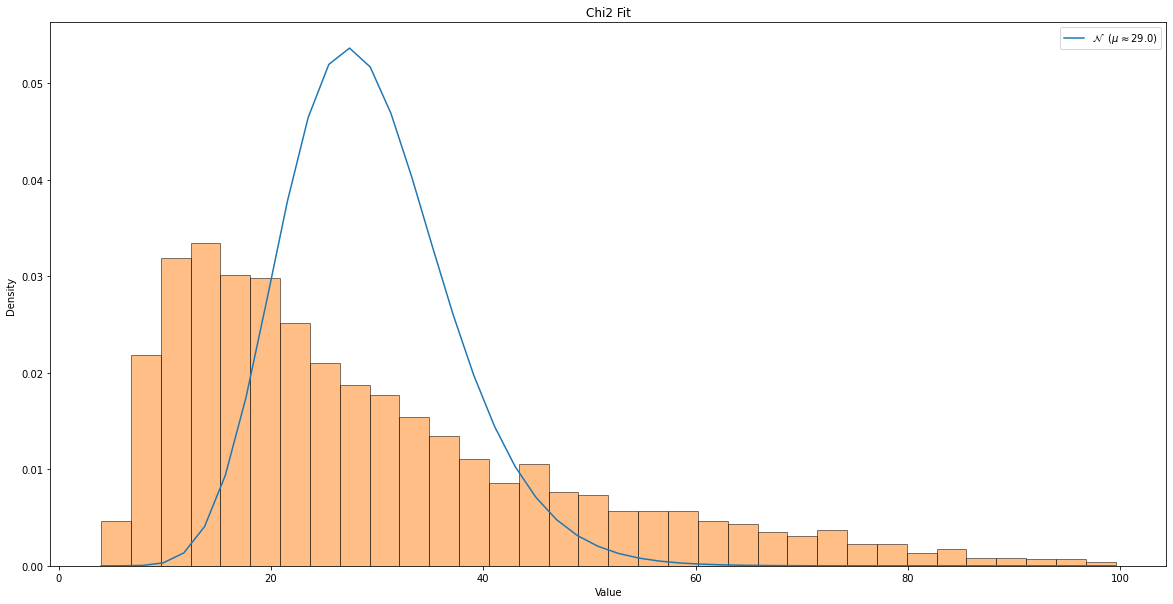

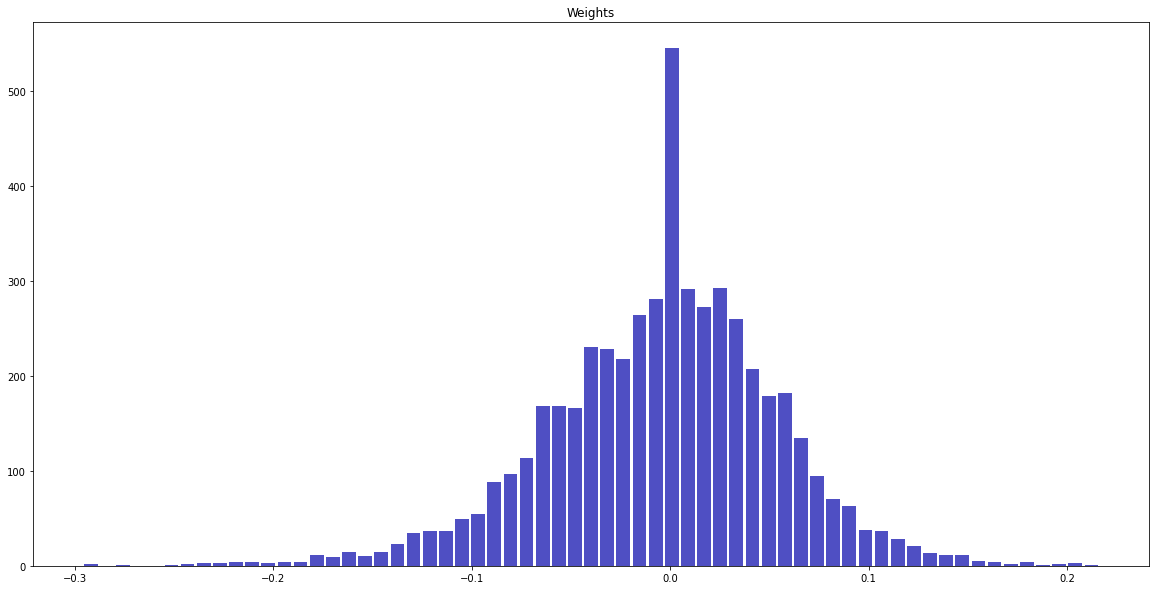

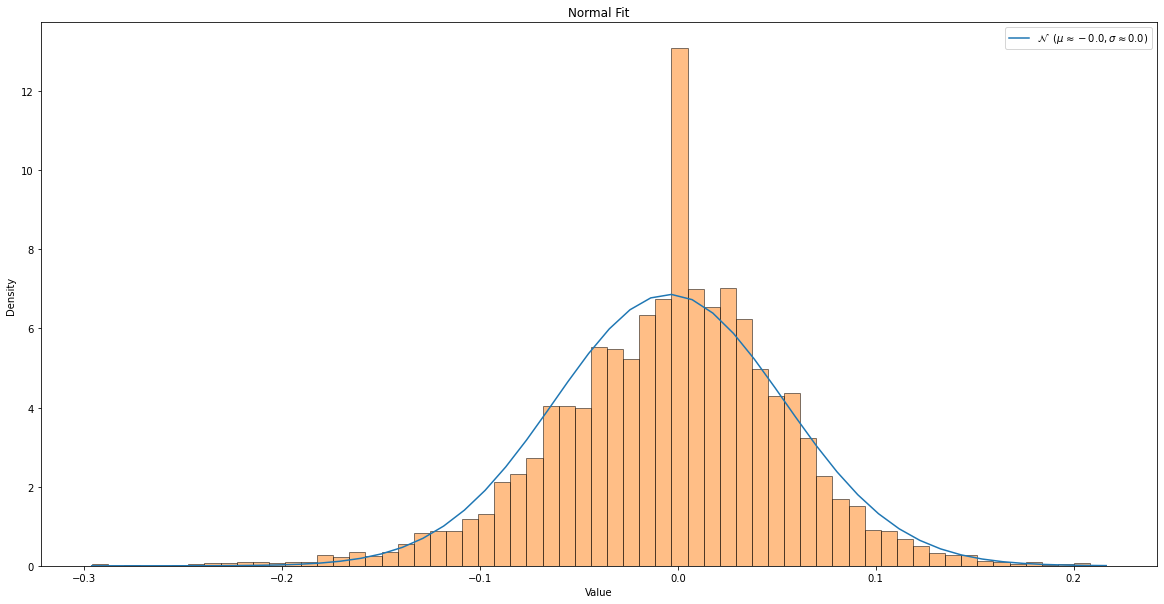

In [240]:
plt.hist(npuncert1, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Uncertainty')
plt.show()
#chi2
std = np.std(npuncert1, ddof=1)
mean = np.mean(npuncert1)
domain = np.linspace(np.min(npuncert1), np.max(npuncert1))
plt.plot(domain, chi2.pdf(domain, mean), 
        label='$\mathcal{N}$  ' + f'$( \mu \\approx {round(mean)})$')
plt.hist(npuncert1, bins='auto', edgecolor='black', alpha=.5, density=True)
plt.title("Chi2 Fit")
plt.xlabel("Value")
plt.ylabel("Density ")
plt.legend()
plt.show()

#__________
plt.hist(torch.flatten(linear_weights).detach().numpy(), bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Weights')
plt.show()
#norm 
std = np.std(linear_weights.detach().numpy(), ddof=1)
mean = np.mean(linear_weights.detach().numpy())
domain = np.linspace(np.min(linear_weights.detach().numpy()), np.max(linear_weights.detach().numpy()))
plt.plot(domain, norm.pdf(domain, mean, std), 
        label='$\mathcal{N}$  ' + f'$( \mu \\approx {round(mean)}, \sigma \\approx {round(std)})$')
plt.hist(torch.flatten(linear_weights).detach().numpy(), bins='auto', edgecolor='black', alpha=.5, density=True)
plt.title("Normal Fit")
plt.xlabel("Value")
plt.ylabel("Density ")
plt.legend()
plt.show()

#__________

## Correlation between Uncertainty and Size of Weights

Pearsons correlation: -0.164


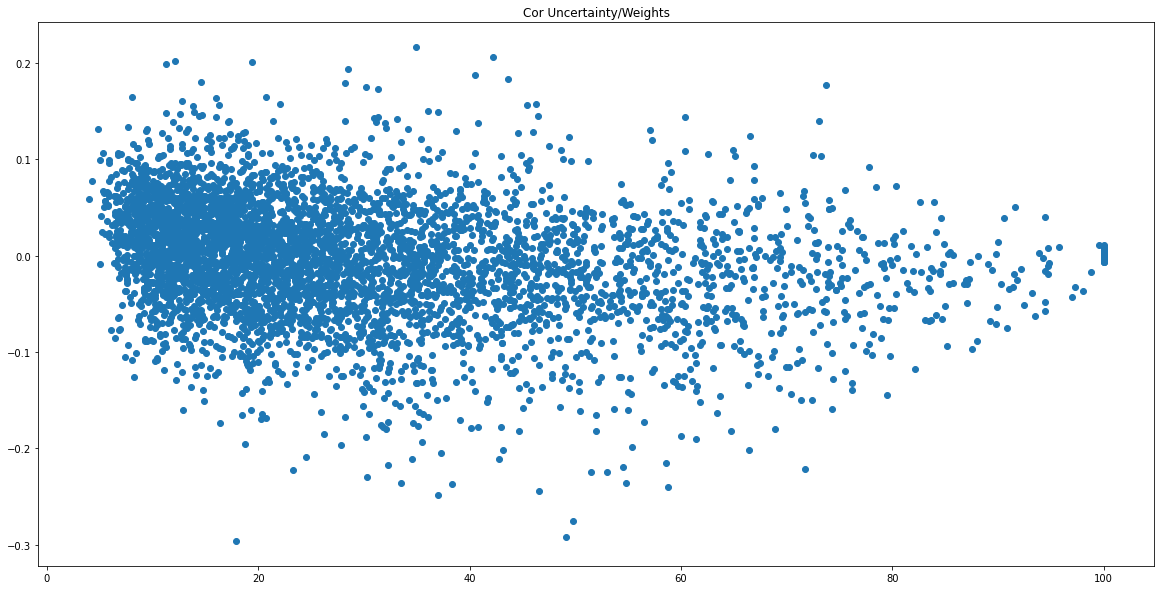

In [157]:
linear_weights_flattened = torch.flatten(linear_weights)
linear_uncertainties_flattened = torch.flatten(MNIST_NN_Std_prec_00001[4])
plt.scatter(linear_uncertainties_flattened.detach().numpy(), linear_weights_flattened.detach().numpy())
plt.title('Cor Uncertainty/Weights')
corr, _ = pearsonr(linear_uncertainties_flattened.detach().numpy(), linear_weights_flattened.detach().numpy())
print('Pearsons correlation: %.3f' % corr)